In [7]:
import pandas as pd
import numpy as np
#function to prepocessing data 
def process(x): 
    row_data=pd.read_csv(x, index_col='PassengerId')
    print(x,"missing value","\n",row_data.isnull().sum())
    #split the name
    a=[]
    for i in row_data['Name']:
        a.append(i.split(','))
    a=np.array(a)
    #get the prefix
    b=[]
    for i in a[:,1]:
        b.append(i.split('.',maxsplit=1))
    b=np.array(b)
    #get the numpy array of first_name, last_name and prefix, and add prefix to row_data
    first_name=a[:,0]
    last_name=b[:,1]
    prefix=b[:,0]
    row_data['prefix']=prefix
    #fill the Embarked with the most 
    row_data['Embarked'] = row_data['Embarked'].fillna(row_data['Embarked'].value_counts().idxmax())
    #fill the Fare with mean
    row_data['Fare']=row_data['Fare'].fillna(row_data['Fare'].mean())
    #fill the Age by mean group by prefix
    row_data.loc[row_data['Age'].isnull(), 'Age'] = row_data.groupby("prefix").transform(lambda x: x.fillna(x.median()))
    #fill the rest Age by mean
    row_data['Age']=row_data['Age'].fillna(row_data['Age'].mean())
    #fill the cabin none with 0 not none with 1
    row_data.loc[row_data['Cabin'].notnull(),'Cabin']=1
    row_data.loc[row_data['Cabin'].isnull(),'Cabin']=0
    #get the dummy of sex
    Sex_dummy=pd.get_dummies(row_data['Sex'],drop_first=True)
    #get the dummies of Embarked
    Embarked_dummy=pd.get_dummies(row_data['Embarked'],prefix='Embarked',drop_first=True)
    #get the dummies of Pclass
    Pclass_dummy=pd.get_dummies(row_data['Pclass'],prefix='Pclass',drop_first=True)
    #get data DataFrame
    data=pd.DataFrame()
    data=pd.concat([row_data[['Age','SibSp','Parch','Fare','Cabin']],Pclass_dummy,Sex_dummy,Embarked_dummy],axis=1)
    #check whether the dataset is train or test
    if x=='test.csv':
        return data
    else:
        target=row_data['Survived']
        return data,target
#function to get the test result
def getresult(x,y):
    result=pd.DataFrame(index=x_test.index)
    result['Survived']=x
    result.to_csv(y)

train.csv missing value 
 Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64


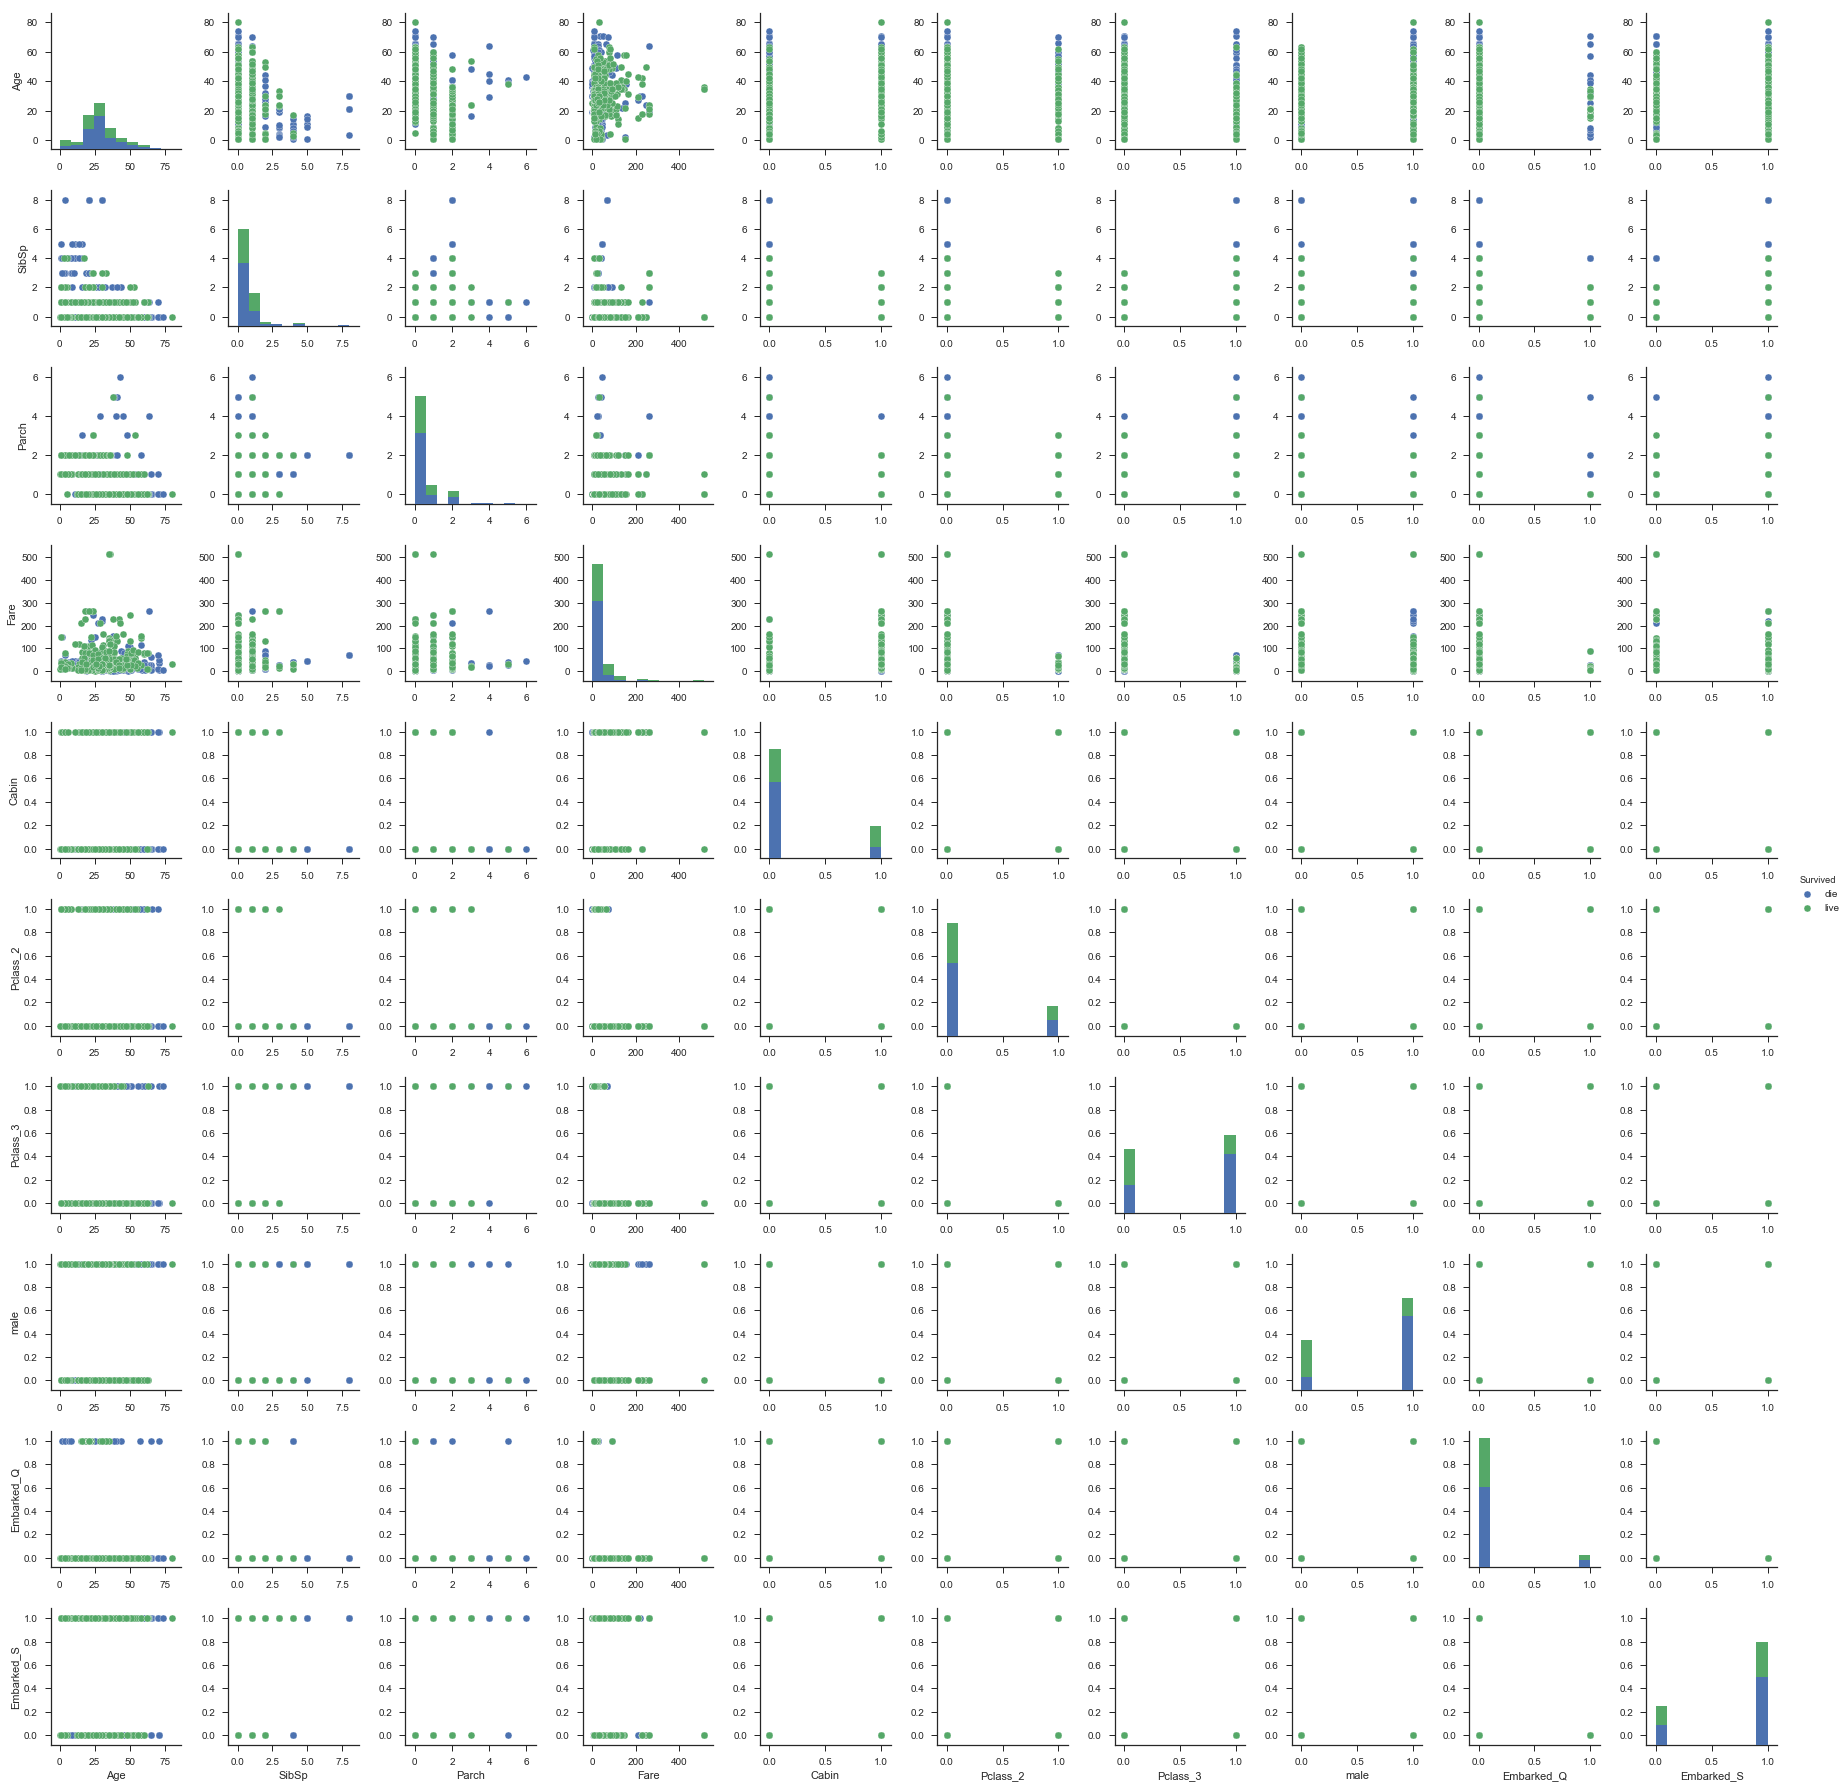

In [10]:
#get the pairplot of all features.
data,label=process('train.csv')
%matplotlib inline
import seaborn as sns

sns.set(style="ticks")
all_data=pd.concat([data,label],axis=1)
all_data.loc[all_data['Survived']==1,'Survived']="live"
all_data.loc[all_data['Survived']==0,'Survived']="die"
sns.pairplot(all_data,hue="Survived")

In [ ]:
#other feature processing but we do not use.
fare_dummy=[]
for i in data['Fare']:
    if i>=data['Fare'].mean():
        fare_dummy.append(1)
    else:
        fare_dummy.append(0)
fare_dummy=np.array(fare_dummy)
data['Fare']=fare_dummy

SibSp_dummy=[]
for i in data['SibSp']:
    if i==0:
        SibSp_dummy.append(0)
    else:
        SibSp_dummy.append(1)
SibSp_dummy=np.array(SibSp_dummy)
data['SibSp']=SibSp_dummy

Parch_dummy=[]
for i in data['Parch']:
    if i==0:
        Parch_dummy.append(0)
    else:
        Parch_dummy.append(1)
Parch_dummy=np.array(Parch_dummy)
data['Parch']=Parch_dummy

data.loc[(data['Parch']==1),'SibSp']=1
data=data.drop(['Parch'],axis=1)

In [24]:
data=data.drop(['SibSp','Parch','Fare','Cabin'],axis=1)
data=data.values
label=label.values

from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
import random

random_state = 5
rkf = RepeatedKFold(n_splits=5, n_repeats=1, random_state=random_state)
k=0
score_ada=[]
score_bag=[]
score_frt=[]
score_Mnb=[]
score_log=[]

for train, test in rkf.split(data):
    X_train, X_test = data[train], data[test]
    y_train, y_test = label[train], label[test]
    
    ada=AdaBoostClassifier()
    ada_model=ada.fit(X_train,y_train)
    score_ada.append(ada_model.score(X_test,y_test))
    
    bag=BaggingClassifier()
    bag_model=bag.fit(X_train,y_train)
    score_bag.append(bag_model.score(X_test,y_test))
    
    frt=RandomForestClassifier()
    frt_model=frt.fit(X_train,y_train)
    score_frt.append(frt_model.score(X_test,y_test))
    
    Mnb=MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(20,20,20), random_state=1)
    Mnb_model=Mnb.fit(X_train,y_train)
    score_Mnb.append(Mnb_model.score(X_test,y_test))
    
    log=LogisticRegression()
    log_model=log.fit(X_train,y_train)
    score_log.append(log_model.score(X_test,y_test))
    
print("Average of ada",sum(score_ada)/len(score_ada))
print("Average of bag",sum(score_bag)/len(score_bag))
print("Average of frt",sum(score_frt)/len(score_frt))
print("Average of mlp",sum(score_Mnb)/len(score_Mnb))
print("Average of log",sum(score_log)/len(score_log))

Average of ada 0.801337015881
Average of bag 0.80692360806
Average of frt 0.804682694118
Average of mlp 0.810300671646
Average of log 0.793471847342


In [9]:
#get the x_test
x_test=process('test.csv')
x_test=x_test.drop(['SibSp','Parch','Fare','Cabin'],axis=1)

test.csv missing value 
 Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64


In [26]:
#MLPClassifier

scaler=preprocessing.MinMaxScaler().fit(data) 
X_train_transformed=scaler.transform(data)
Mnb=MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(20,20,20), random_state=1)
Mnb_model=Mnb.fit(X_train_transformed,label)
X_test_transformed=scaler.transform(x_test)
mlp_result=Mnb_model.predict(X_test_transformed)
getresult(mlp_result,'final_mlp.csv')#Highest score 0.79425

#adaboosting
ada=AdaBoostClassifier()
ada_model=ada.fit(X_train_transformed,label)
ada_result=ada_model.predict(X_test_transformed)
getresult(ada_result,'final_ada.csv')

#bagging
bag=BaggingClassifier()
bag_model=bag.fit(X_train_transformed,label)
bag_result=bag_model.predict(X_test_transformed)
getresult(bag_result,'final_bag.csv')

#RandomForest
frt=RandomForestClassifier()
frt_model=frt.fit(X_train_transformed,label)
frt_result=frt_model.predict(X_test_transformed)
getresult(frt_result,'final_frt.csv')

#logsitic Regression
log=LogisticRegression()
log_model=log.fit(X_train_transformed,label)
log_result=log_model.predict(X_test_transformed)
getresult(log_result,'final_log.csv')


All of the idea of process and models come up with by ourselves. None of the kernel we use.

1. How did you do to wrangle, prepare, cleanse the data?

   There were a lot of missing values in the data set that we need to deal with first.
   After a brief discussion, we all believed that the Age variable was the most important variable for good prediction.
   So we filled up the Ages by the group of persons' prefix(eg. Mrs, Miss, Master.... from Name feature). 
   We set missing age values to the median value of people from the same group.
   We used the median value of the whole data set for the missing values in variable Fare.
   Then we set "0" for "missing" and "1" for "not missing" for the variable Cabin.
   
2. How did you analyze, identify patterns, and explore the data?

   After fixing the missing values, we employed dummy variables for vairables Pclass, sex and Embarked, then dropped the first to avoid repeated representation. We then tried a few approaches. For example, we seperated Fare into two groups as "high" and "low" in order to figure out if that person was alone on the borad. However, we did not choose those variables in our model in the end because more features might lead to overfitting, which would decrease the accuracy of our prediction .

3. Improve prediction from the lab and pick the best to submit to kaggle.com:   
   a. What are the models you ran (you should run at least 5)?
   
   We ran 5 models to do the classification. They were LogisticRegression, RandomForestClassifier, BaggingClassifier, AdaBoostClassifier and MLPClassifier.
   
   b. What are the features/variables in the data you chose to build your models?
   
   The features we used in our model were Age, Pclass, Sex and Embarked. 
   
   c. How and why did you pick the features/variables?
   
   We chose Age, Pclass, Sex and Embarked based on the scattered plot and mixed selection.
   
   d. What is the model you picked to submit and its score rated by kaggle.com (it should be higher than 0.75598)?
   
   Our highest score is 0.79425, which comes from the prediction of the model MLPclassifier with 3 hiden-layers and 20 nodes in each.
   
   e. What is/are the parameter value/values as a result of your parameter tuning?
      
      Our Mlpclassifier model used 3 layers with 20 nodes in each layer.
   
   f. How did you pick the value(s)?

      For the MLPClassifier model, the most important parameters were the number of layers and the number of nodes in each layers.
      We applied 5-fold validation on the training data set which was provided by the website. Then we tried different combination of number of layers and number of nodes. After many attempts, we concluded to use the 3 layers with 20 nodes, because this combination gave the highest average accuracy.
   
4. Answer the below questions about SettingWithCopyWarning in pandas   

    a.	What is SettingWithCopyWarning? Please summarize.

    It's a warning generated by pandas when you try to use Chained assignment. Chained assignment is an action you  assign values to the result made by chained selecting. Simply said, when pandas do not know you want to assign a value to original DataFrame or copy of DataFrame.

    b.How did you make sure that the warning is not applicable in your cases?

    we check the result which was just assigned after the warning message. If what we wanted to change really changed, the warning was not applicable in our cases.

    c.What can you do to avoid the warning according to the web? Please summarize.

    1. Using .loc[], .iloc[], .ix[] and so on. But these might cause Hidden chaining.
    2. Turning off the warning by using “mode.chained_assignment” option, ONLY use it when you have a full grasp of what you are doing.
    3. Tell pandas what you want to assign is an original DataFrame or a copy.
    4. We can create a new dataframe from the old one, and use pd.concat() to concatenate the new one and the old one to get the dataframe with both new data and original data.